In [1]:
import quandl
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression,LassoLarsIC
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Question 1

##### Monthly House Price Data

In [2]:
monthly_house_price_df = pd.read_excel("./Monthly.xls");  # read the excel file


house_price = monthly_house_price_df.rename(columns={"Unnamed: 0":"Date"})
unwanted_columns = ['INDEX Q1 1993=100', 'Seasonally Adjusted Index', 'Monthly % Change (SA)',
                    'Year % Change','Latest 3 months on previous 3 months']

house_price['Date'] = pd.to_datetime(house_price["Date"]) # convert to datetime
house_price = house_price.set_index('Date').loc[:'2016-12-31'] # set index to date and selct data from 1992-01-01 to last data
house_price = house_price.drop(unwanted_columns,axis=1)

# calculate and add a new column for montly returns
house_price['Price Monthly Returns'] = (house_price['Average House Price'] / house_price['Average House Price'].shift()) - 1
house_price.head()

,Average House Price,Price Monthly Returns
Date,,
1991-01-01,53051.721106,NaN
1991-02-01,53496.798746,0.008390
1991-03-01,52892.861606,-0.011289
1991-04-01,53677.435270,0.014833
1991-05-01,54385.726747,0.013195


##### FTSE Ticker Data

In [3]:
ftse = pd.read_csv("./FTSE100.csv") # loat the csv file

ftse['Date'] = pd.to_datetime(ftse["Date"]) # convert to datetime

ftse = ftse.set_index('Date').loc[:'2016-12-31']  # set index to date and selct data from 1992-01-01 to 2016-12-31
ftse.drop(["Open","High","Low","Close","Volume"],inplace=True,axis=1)  # drop unwanted columns

ftse = ftse.sort_index().loc[:'2016-12-31']
ftse['FTSE Returns'] = (ftse['Adj Close'] / ftse['Adj Close'].shift()) - 1  # calculate and add a new column for montly returns

ftse.head()

,Adj Close,FTSE Returns
Date,,
1991-01-01,2170.300049,NaN
1991-02-01,2380.899902,0.097037
1991-03-01,2456.500000,0.031753
1991-04-01,2486.199951,0.012090
1991-05-01,2499.500000,0.005350


##### Regression Model - Correlation Coeffient and Constant

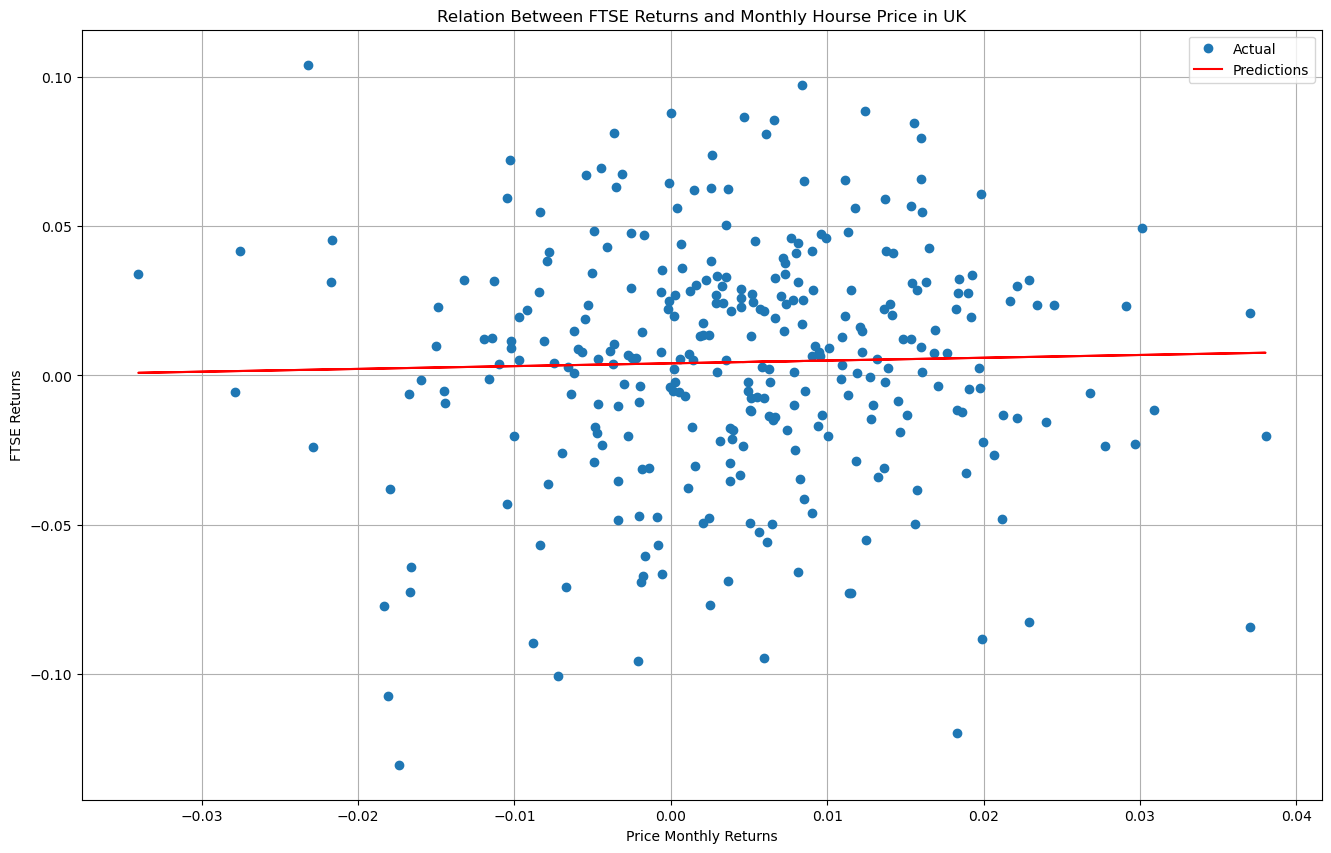

In [4]:
X = house_price[['Price Monthly Returns']].dropna()  # select the features
y = ftse['FTSE Returns'].dropna()  # select the target

linreg = stats.linregress(house_price['Price Monthly Returns'].dropna(), y)  # calculate the linear regression

x = house_price['Price Monthly Returns'].dropna()

fig, ax = plt.subplots(figsize=(16,10));
ax.plot(x, y, 'o', label='Actual')
ax.plot(x, linreg.intercept + linreg.slope*x, 'r', label='Predictions')
ax.set_title("Relation Between FTSE Returns and Monthly Hourse Price in UK")
ax.set_xlabel('Price Monthly Returns')
ax.set_ylabel('FTSE Returns')  # plot the scatter plot
ax.grid(True)
ax.legend()
plt.show();

In [5]:
print(f"Model Slope: {linreg.slope}")
print(f"Model Intercept: {linreg.intercept}")

print(f"Corr Coe: {linreg.rvalue}")
print(f"p-value: {linreg.pvalue}")  # calculate the p-value

# since p-value is more than 0.05, 
# we can't reject the null hypothesis and 
# conclude that there is no correlation 
# between the two variables

Model Slope: 0.09324142754349966
Model Intercept: 0.004047837686662456
Corr Coe: 0.026551295701909915
p-value: 0.6409049000031651


# Question 2

##### College data

In [6]:
college = pd.read_csv("./College.csv")
college = college.rename(columns={"Unnamed: 0":"College Name"})  # rename the column

# select necessary features
college_df = college[['College Name', 
 'Apps', 
 'Enroll', 
 'Top10perc',
 'Top25perc', 
 'Outstate', 
 'Grad.Rate']]
college_df.head()

,College Name,Apps,Enroll,Top10perc,Top25perc,Outstate,Grad.Rate
0,Abilene Christian University,1660,721,23,52,7440,60
1,Adelphi University,2186,512,16,29,12280,56
2,Adrian College,1428,336,22,50,11250,54
3,Agnes Scott College,417,137,60,89,12960,59
4,Alaska Pacific University,193,55,16,44,7560,15


In [7]:
X_college =  college_df[['Apps', 'Enroll', 'Top10perc', 'Top25perc', 'Outstate']]  # select the features
y_college = college_df['Grad.Rate'].dropna() # select the target


coeff=college_df.corr(numeric_only=True)  # calculate the correlation coefficient
coeff

,Apps,Enroll,Top10perc,Top25perc,Outstate,Grad.Rate
Apps,1.000000,0.846822,0.338834,0.351640,0.050159,0.146755
Enroll,0.846822,1.000000,0.181294,0.226745,-0.155477,-0.022341
Top10perc,0.338834,0.181294,1.000000,0.891995,0.562331,0.494989
Top25perc,0.351640,0.226745,0.891995,1.000000,0.489394,0.477281
Outstate,0.050159,-0.155477,0.562331,0.489394,1.000000,0.571290
Grad.Rate,0.146755,-0.022341,0.494989,0.477281,0.571290,1.000000


In [8]:
# same as above
r_regression(X_college, y_college)  # calculate the linear regression

array([ 0.1467546 , -0.02234104,  0.49498923,  0.47728116,  0.57128993])

In [9]:
def forward_stepwise_regression_pvalue(X, y, alpha=0.05):
    selected_vars = []
    remaining_vars = list(X.columns)
    while len(remaining_vars) > 0:
        p_values = []
        for var in remaining_vars:
            model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit()
            p_value = model.pvalues[var]
            p_values.append((var, p_value))
        best_var, min_p_value = min(p_values, key=lambda x: x[1])
        if min_p_value < alpha:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
        else:
            break
    return selected_vars

In [10]:
# calculate the forward regression with p-value
pvalue_selected_features = forward_stepwise_regression_pvalue(X_college, y_college) 

reg_lasso = LassoLarsIC(criterion='bic')
reg_lasso.fit(X_college, y_college) 
lasso_bic_selected = list(X_college.columns[reg_lasso.coef_ != 0])

print(f"p-value selected features: {pvalue_selected_features}")
print(f"Lasso BIC selected features: {lasso_bic_selected}")

p-value selected features: ['Outstate', 'Top25perc']
Lasso BIC selected features: ['Apps', 'Enroll', 'Top25perc', 'Outstate']


In [11]:
# Model with all five predictors

model_all = LinearRegression()
model_all.fit(X_college, y_college)  # fit the model

y_pred_training = model_all.predict(X_college)  # make predictions on the training data

residual = r2_score(y_college,y_pred_training)

print(f"Accuracy Score: {round(residual*100,2)}%")  # calculate the mean absolute error

Accuracy Score: 38.62%


In [12]:
# Model with pvalue selected features predictors

model_pvalue_selected = LinearRegression()

model_pvalue_selected.fit(college_df[pvalue_selected_features], y_college)  # fit the model

y_pred_training = model_pvalue_selected.predict(college_df[pvalue_selected_features])  # make predictions on the training data

residual = r2_score(y_college,y_pred_training)

print(f"Accuracy Score: {round(residual*100,2)}%")  # calculate the mean absolute error

Accuracy Score: 37.78%


In [13]:
# Model with LassoLarsIC BIC

lasso_model_selected = LinearRegression()

lasso_model_selected.fit(college_df[lasso_bic_selected], y_college)  # fit the model

y_pred_training = lasso_model_selected.predict(college_df[lasso_bic_selected])  # make predictions on the training data

residual = r2_score(y_college,y_pred_training)

print(f"Accuracy Score: {round(residual*100,2)}%") 

Accuracy Score: 38.57%


In [14]:
# prediction for Carnegi Mellon University
cmu_df = college_df[college_df['College Name'] == 'Carnegie Mellon University']  # select the data for the university
cmu_X = cmu_df[['Apps', 'Enroll', 'Top10perc', 'Top25perc', 'Outstate']]

In [15]:
grad_rate = model_all.predict(cmu_X)  # make predictions on the training data
grad_rate = grad_rate[0]
print(f"Graduation Rate: {round(grad_rate,2)}%")  # calculate the mean absolute error

Graduation Rate: 89.2%


# Q3

In [16]:
# gdp_growth =  pd.read_csv("./gdp_growth.csv",skiprows=3)
# transport_service =  pd.read_csv("./transport_service.csv",skiprows=3)



# unnecessary_columns = ["Country Name","Country Code","Indicator Name", "Indicator Code","Unnamed: 67"]


# # Transport Service (% of Commercial Service Export) for Ghana
# gh_ts = transport_service[transport_service['Country Name'] == 'Ghana']
# gh_ts = gh_ts.drop(unnecessary_columns, axis=1).transpose().rename(columns={83:"Transport Service"})
# gh_ts.index = pd.to_datetime(gh_ts.index)  # convert the index to datetime format


# # gdp growth data for Ghana
# gh_gdp = gdp_growth[gdp_growth['Country Name'] == 'Ghana']
# gh_gdp = gh_gdp.drop(unnecessary_columns, axis=1).transpose().rename(columns={83:"GDP Growth"})
# gh_gdp.index = pd.to_datetime(gh_gdp.index)  # convert the index to datetime format


# # plot data
# fig, ax = plt.subplots(figsize=(16,10));
# plt.plot(gh_ts.index, gh_ts["Transport Service"], label="Transport Service");
# plt.plot(gh_gdp.index, gh_gdp["GDP Growth"], label="Annual GDP Growth");
# plt.xlabel("Year");
# plt.ylabel("Percentage (%) Growth");
# plt.title("Transport Service (% of Commercial Service Export) and Annual GDP Growth for Ghana");
# plt.legend();
# plt.grid(True);
# plt.show();

# # fig, ax = plt.subplots(figsize=(16,10));
# # ax.scatter(gh_gdp["GDP Growth"],gh_ts["Transport Service"])
# # ax.set_title("GDP Growth vs Transport Service")
# # ax.set_ylabel("Transport Service")
# # ax.set_xlabel("GDP Growth")
# # ax.grid(True)
# # plt.show()

# # slice data from 1960 to 2020
# gh_ts = gh_ts.loc[:"2020-01-01"]
# gh_ts["Transport Service"].fillna(gh_ts["Transport Service"].mean(), inplace=True)
# gh_ts

# gh_gdp = gh_gdp.loc[:"2020-01-01"]
# gh_gdp["GDP Growth"].fillna(gh_gdp["GDP Growth"].mean(), inplace=True)
# gh_gdp


# # Extract features and build model
# X =  gh_gdp[["GDP Growth"]]  # select the predictor variables
# y = gh_ts["Transport Service"]  # select the response variable

# model = LinearRegression()
# model.fit(X.values.reshape(-1,1),y)
# y_pred = model.predict(X.values.reshape(-1,1))
# mae =  mean_absolute_error(y, y_pred)  # calculate the mean absolute error



# fig, ax = plt.subplots(figsize=(16,10));
# ax.scatter(gh_gdp["GDP Growth"],gh_ts["Transport Service"])
# ax.plot(gh_gdp["GDP Growth"], model.intercept_ + model.coef_*gh_gdp["GDP Growth"], 'r', label='Predictions')
# ax.set_title("GDP Growth vs Transport Service")
# ax.set_ylabel("Transport Service")
# ax.set_xlabel("GDP Growth")
# ax.grid(True)
# ax.legend()
# plt.show()

# # extract 2021 GDP Growth for ghana
# gdp_2021= gdp_growth[gdp_growth['Country Name'] == 'Ghana']["2021"].values[0]

# # predict Annual GDP Growth for Ghana for year 2021
# transport_service_2021_ghana = model.predict([[gdp_2021]])[0]

# print(f"Mean Absolute Error: {round(mae,2)}")
# print(f"Predicted Transport Service Growth for Ghana in 2021: {round(gdp_2021,2)}")

# Question 3

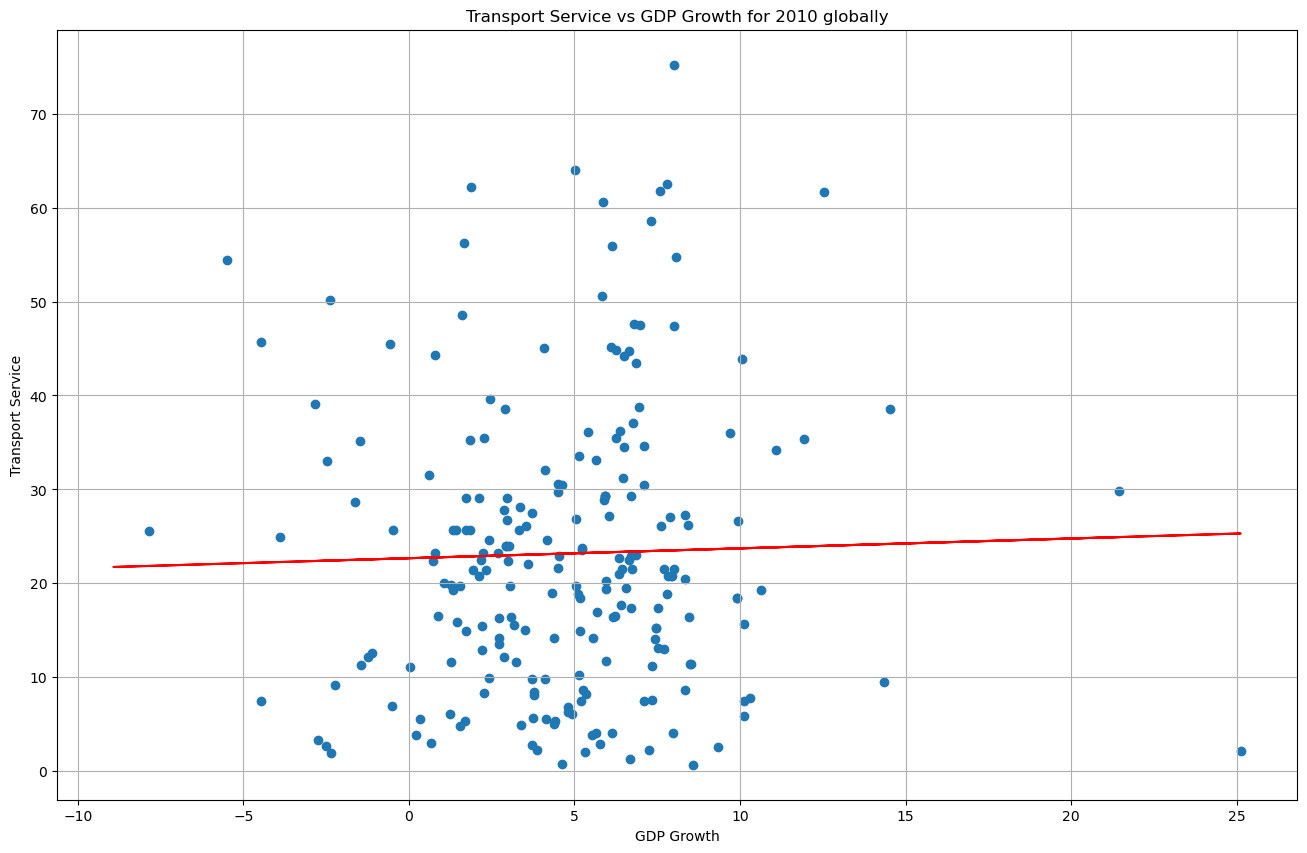

Correlation between GDP Growth and Transport Service: 0.0367
Model's Mean Absolute Error: 10.02
Predicted Transport Service (% of commercial service export) for Ghana in 2021: 23.24


In [17]:
gdp_growth =  pd.read_csv("./gdp_growth.csv",skiprows=3)
transport_service =  pd.read_csv("./transport_service.csv",skiprows=3)


cor1 = gdp_growth["2010"].corr(transport_service["2010"])

gdp_growth_2010 = gdp_growth['2010'].fillna(gdp_growth['2010'].mean())  
X = gdp_growth_2010.values.reshape(-1,1)   # select the predictor variables
y = transport_service['2010'].fillna(transport_service['2010'].mean())  # select the response variable

model = LinearRegression()  # create a linear regression model
model.fit(X, y)  # fit the model
y_pred = model.predict(X)  # make predictions on the training data
mae =  mean_absolute_error(y, y_pred)  # calculate the mean absolute error

# get ghana's gdp growth data for 2021
ghana_gdp_growth_2021 = gdp_growth[gdp_growth['Country Name'] == 'Ghana']['2021'].values[0]

# predict transport service (% of commercial service export) for ghana in 2021
transport_service_ghana_2021 =  model.predict([[ghana_gdp_growth_2021]])[0]


fig, ax = plt.subplots(figsize=(16,10));
plt.scatter(gdp_growth["2010"],transport_service["2010"]);
plt.plot(gdp_growth_2010, model.intercept_ + model.coef_*gdp_growth_2010, 'r', label='Predictions')
plt.title("Transport Service vs GDP Growth for 2010 globally")
plt.ylabel("Transport Service")
plt.xlabel("GDP Growth")
plt.grid(True)
plt.show()


print(f"Correlation between GDP Growth and Transport Service: {round(cor1,4)}")
print(f"Model's Mean Absolute Error: {round(mae,2)}")  # print the mean absolute error
print(f"Predicted Transport Service (% of commercial service export) for Ghana in 2021: {round(transport_service_ghana_2021,2)}")

# Question 4

In [18]:
quandl_api_key = 'hzVQsu_FWk9mhrdwQwzx'
quandl.ApiConfig.api_key =  quandl_api_key
data = quandl.get("ODA/ISR_LUR")

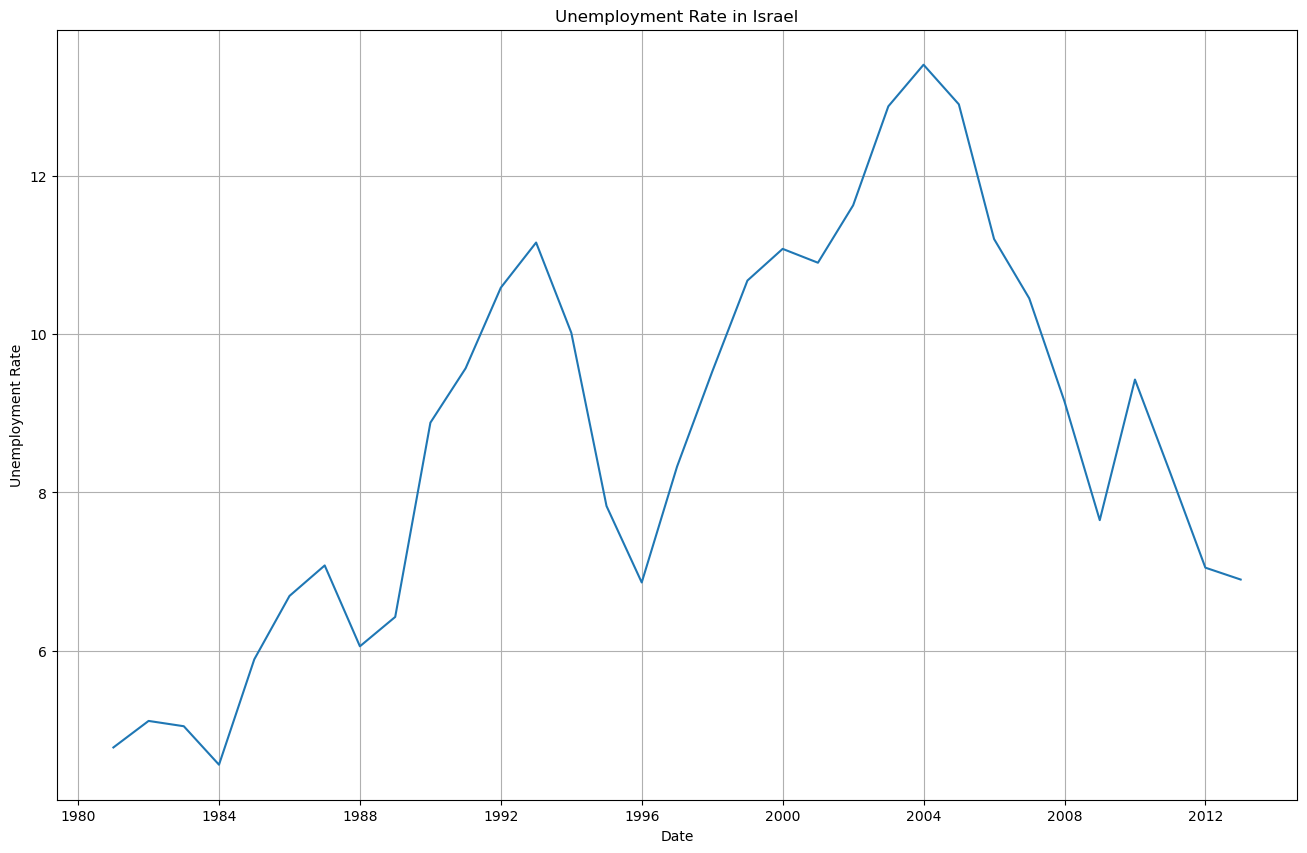

In [19]:
df = data.loc[:'2013-09-02'].reset_index()


fig, ax = plt.subplots(figsize=(16,10));
ax.plot(df['Date'], df['Value']);
ax.set_xlabel('Date');
ax.set_ylabel("Unemployment Rate");
ax.set_title("Unemployment Rate in Israel");
plt.grid(True);
plt.show()

In [20]:
df['Year'] = df["Date"].dt.year

X = df[['Year']]  # select date as predictor
y = df['Value']  # select unemployment rate as target

model =  LinearRegression()  # create a linear regression model
model.fit(X, y)  # fit the model
y_pred = model.predict(X)  # make predictions on the training data

# predict unemployment rate for 2020
va = model.predict(pd.DataFrame({'Year':[2020]}))[0]
print(f"Unemployment Rate for 2020: {round(va,2)}%")  # calculate the mean absolute error

# Calculate accuracy of model
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f"Mean Absolute Percentage Error: {round(mape,2)}%")  # calculate the mean absolute error

Unemployment Rate for 2020: 12.08%
Mean Absolute Percentage Error: 21.99%
